In [56]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
from scipy.linalg import qr
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 14, 12  # делаем картинки крупнее
%config InlineBackend.figure_format = 'retina'  # делаем картинки красивее

In [59]:
class modIsolationTree:
    # строим дерево со случайным поворотом
    def __init__(self, random_state=np.random.RandomState()):
        self.rnd = random_state
        self.clf = IsolationForest(n_estimators=1)
    
    def rotate(self, x):   # просто модифицируем все основные функции алгоритма, подставляя вместо признаков повёрнутые
        return x.dot(self.RotationMaxtrix)   
    def fit(self, x):
        # генерим случайную матрицу поворота
        H = self.rnd.uniform(0, 1, (x.shape[1], x.shape[1]))
        self.RotationMaxtrix, R = qr(H)
        
        self.clf.fit(self.rotate(x))
        return self
    def decision_function(self, x):
        return self.clf.decision_function(self.rotate(x))

In [24]:
class modIsolationForest:  # строим много модифицированных iTree и усредняем
    def __init__(self, n_estimators, random_state=np.random.RandomState()):
        self.trees = np.array([])
        for i in range(n_estimators):
            self.trees = np.append(self.trees, modIsolationTree(random_state))
    def fit(self, x):
        for tree in self.trees:
            tree.fit(x)
        return self
    def decision_function(self, x):
        ans = 0
        for tree in self.trees:
            ans += tree.decision_function(x)
        return ans / len(self.trees)

In [58]:
def anomalyScoresPlot(normal, anomaly):
    rcParams['figure.figsize'] = 16, 3
    plt.scatter(normal, np.zeros_like(normal), marker='|', c='green', s=8000)
    plt.scatter(anomaly, np.zeros_like(anomaly), marker='|', c='red', s=8000)
    plt.tick_params(axis='y', left='off', labelleft='off')
    plt.xlim(min(normal.min(), anomaly.min()), max(normal.max(), anomaly.max()))
    plt.show()

In [57]:
def coolPlot(name, decision_func, train=np.empty((0, 2)), test=np.empty((0, 2)), outliers=np.empty((0, 2))):
    rcParams['figure.figsize'] = 14, 12
    f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[6, 1]})
        
    xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
    Z = decision_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax0.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
    b1 = ax0.scatter(train[:, 0], train[:, 1], c='white')
    b2 = ax0.scatter(test[:, 0], test[:, 1], c='green')
    c = ax0.scatter(outliers[:, 0], outliers[:, 1], c='red')
    ax0.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
    ax0.axis('tight')
    ax0.set_xlim((-5, 5))
    ax0.set_ylim((-5, 5))
       
    b = ax1.scatter(np.zeros_like(y_pred_test), y_pred_test, marker='_', c='green', s=2000)
    c = ax1.scatter(np.zeros_like(y_pred_outliers), y_pred_outliers, marker='_', c='red', s=2000)
    ax1.set_xticks(np.array([]))
    ax1.yaxis.tick_right()
    ax1.set_ylim((y_pred_outliers.min(), y_pred_test.max()))
    
    plt.tight_layout()
    st = f.suptitle(name, fontsize="x-large")
    f.subplots_adjust(top=0.95)
    plt.show()

In [54]:
def aucroc(y_pred_test, y_pred_outliers):
    return roc_auc_score(np.append(np.ones((len(y_pred_test))), -np.ones((len(y_pred_outliers)))), np.append(y_pred_test, y_pred_outliers))

def Solve(clf, train, test_normalities, test_outliers):
    clf.fit(train)
    y_pred_train = clf.decision_function(train)
    y_pred_test = clf.decision_function(test_normalities)
    y_pred_outliers = clf.decision_function(test_outliers)
        
    print("AUC-ROC score: ", aucroc(y_pred_test, y_pred_outliers))
    if train.shape[1] == 2:
        coolPlot("", clf.decision_function, train, test_normalities, test_outliers)
    else:
        anomalyScoresPlot(y_pred_test, y_pred_outliers)
        
    return y_pred_test, y_pred_outliers

In [119]:
def f_measure(y, f, verbose=True):
    right_shots = np.logical_and(f == 1, f == y).sum()
    precision = right_shots / (f == 1).sum()
    recall = right_shots / (y == 1).sum()
    if verbose:
        print("precision = ", precision)
        print("recall = ", recall)
        print("f-measure = ", precision * recall / (0.5 * precision + 0.5 * recall))
    return precision * recall / (0.5 * precision + 0.5 * recall)

def potential_f_measure(normaly_score, anomaly_score):
    rcParams['figure.figsize'] = 16, 3
    f_meas = np.array([])
    for i in np.sort(anomaly_score)[1:]:
        f_meas = np.append(f_meas, f_measure(np.append(np.zeros_like(normaly_score), np.ones_like(anomaly_score)), 
                                             np.append(normaly_score < i, anomaly_score < i), verbose=False))
                      
    print("Potential max f-measure = ", f_meas.max(), ' (thr = ', np.sort(anomaly_score)[f_meas.argmax()], ')')
    plt.plot(np.sort(anomaly_score)[1:], f_meas)

In [60]:
def draw_with_thresholds(thresholds, normals_clusters, all_points):
    rcParams['figure.figsize'] = 16, 3
    thresholds = np.append(thresholds, all_points.max() + 1)
    currentAxis = plt.gca()
    start = all_points.min()
    colors = [(0.7, 0, 0.2, 0.5), (1, 0, 0, 0.5)]
    normal_color = (0, 1, 0, 0.5)
    
    for i in np.arange(len(thresholds)):
        new_one = np.sort(thresholds)[i]
        currentColor = colors[i%2]
        if i in normals_clusters: currentColor = normal_color
        currentAxis.add_patch(plt.Rectangle((start, -1), new_one - start, 2, color=currentColor))
        start = new_one
    
    plt.scatter(all_points, np.zeros_like(all_points), marker='|', c='black', s=8000)
    plt.tick_params(axis='y', left='off', labelleft='off')
    plt.ylim(-1, 1)
    plt.xlim(all_points.min(), all_points.max())
    plt.show()

In [99]:
# получаем номера кластеров, которые для данных разбиение объявляются нормалиями
def get_normals_clusters(n_of_cluster, thresholds):
    normals_clusters = set()
    for i in np.argsort(np.bincount(n_of_cluster))[::-1]:
        if i - 1 in normals_clusters or i + 1 in normals_clusters:
            break
        normals_clusters.add(i)
    return normals_clusters

def apply_threshold(normal, anomaly, n_of_splits, verbose=True):
    all_points = np.append(normal, anomaly)  # множество всех точек
    sorted_data = np.sort(all_points)  # отсортированные точки
    differences = sorted_data[1:] - sorted_data[:-1]    # множество расстояний между соседними
    
    # пороги разбиения на группы
    thresholds = (sorted_data[:-1] + differences / 2)[np.argsort(differences)[::-1][:n_of_splits]]
    # номер группы для каждой точки
    n_of_cluster = np.array([all_points > threshold for threshold in thresholds]).sum(axis=0)
    # множество кластеров нормалий
    normals_clusters = get_normals_clusters(n_of_cluster, thresholds)
    # максимальный размер кластера аномалий, T
    T = np.sort(np.bincount(n_of_cluster))[::-1][len(normals_clusters)]
    # предсказание (1 - аномалия, 0 - нормалия)
    f = np.array([not n in normals_clusters for n in n_of_cluster])
    
    if verbose:
        print("T = ", T)
        print("Anomalies Fraction = ", f.sum() / len(sorted_data), "%")
        draw_with_thresholds(thresholds, normals_clusters, sorted_data)
        return f
        
    return T, f.sum() / len(sorted_data), len(normals_clusters)

In [88]:
def analize_threshold(normal, anomaly, limit_steps=-1):
    T_dynamics = []
    AnomFraction_dynamics = []
    N_of_normalies_clusters = []
    
    if limit_steps == -1:
        limit_steps = len(normal) + len(anomaly) - 1
    for n_of_splits in range(1, limit_steps):
        T, anom_frac, N_of_norm = apply_threshold(normal, anomaly, n_of_splits, False)
        
        T_dynamics.append(T)
        AnomFraction_dynamics.append(anom_frac)
        N_of_normalies_clusters.append(N_of_norm)
        
    all_data = np.sort(np.append(normal, anomaly))
    differences = all_data[1:] - all_data[:-1]

    fig = plt.figure(figsize=(16, 14))
    ax = fig.add_subplot(411)
    ax.plot(np.sort(differences)[::-1])
    ax.legend(['Differences descending'])
    #plt.axvline(x = 15, lw=3, c='black')
    ax = fig.add_subplot(412)
    ax.plot(T_dynamics, color='m')
    ax.legend(['T'])
    #plt.axvline(x = 15, lw=3, c='black')
    ax = fig.add_subplot(413)
    ax.plot(AnomFraction_dynamics, color='red')
    ax.legend(['Fraction of anomalies in forecast'])
    #plt.axvline(x = 15, lw=3, c='black')
    ax = fig.add_subplot(414)
    ax.plot(N_of_normalies_clusters, color='green')
    ax.legend(['Number of normalies clusters'])
    #plt.axvline(x = 15, lw=3, c='black')
    plt.show(fig)

# ПРИМЕНЯЕМ К САТТЕЛИТУ!

In [52]:
DF = pd.read_csv("satellite.csv", sep=';', header=None)
del DF[36]
DF

DF_test = pd.read_csv("satellite_test.csv", sep=';', header=None)
ans = (DF_test[36] == 2) | (DF_test[36] == 4) | (DF_test[36] == 5)
del DF_test[36]

AUC-ROC score:  0.70569330895


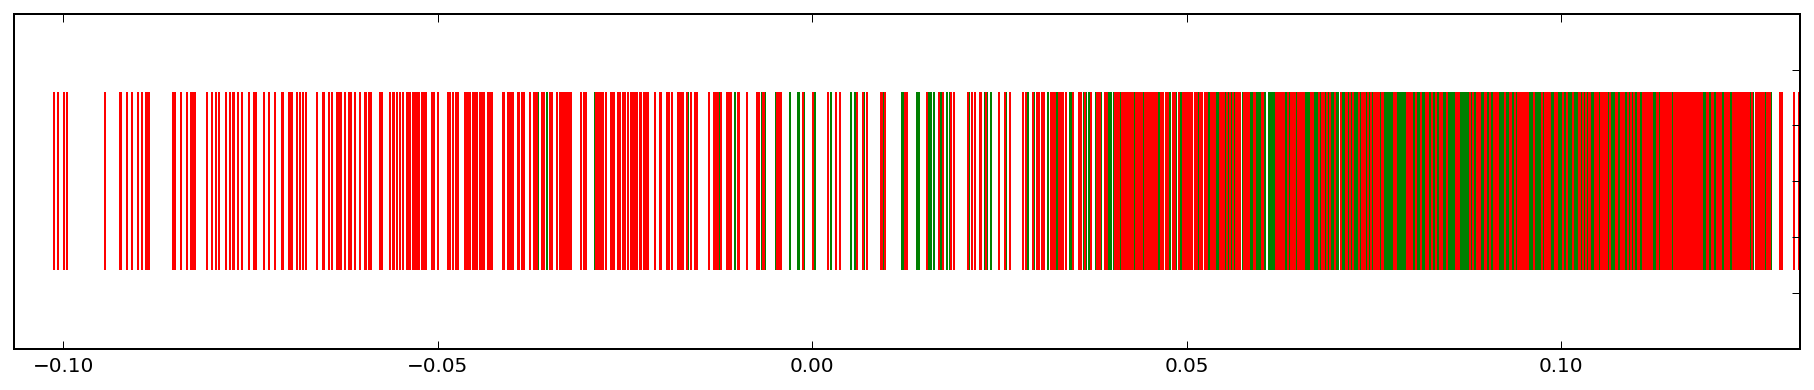

In [53]:
normaly_score, anomaly_score = Solve(modIsolationForest(1000), DF, DF_test[~ans], DF_test[ans])

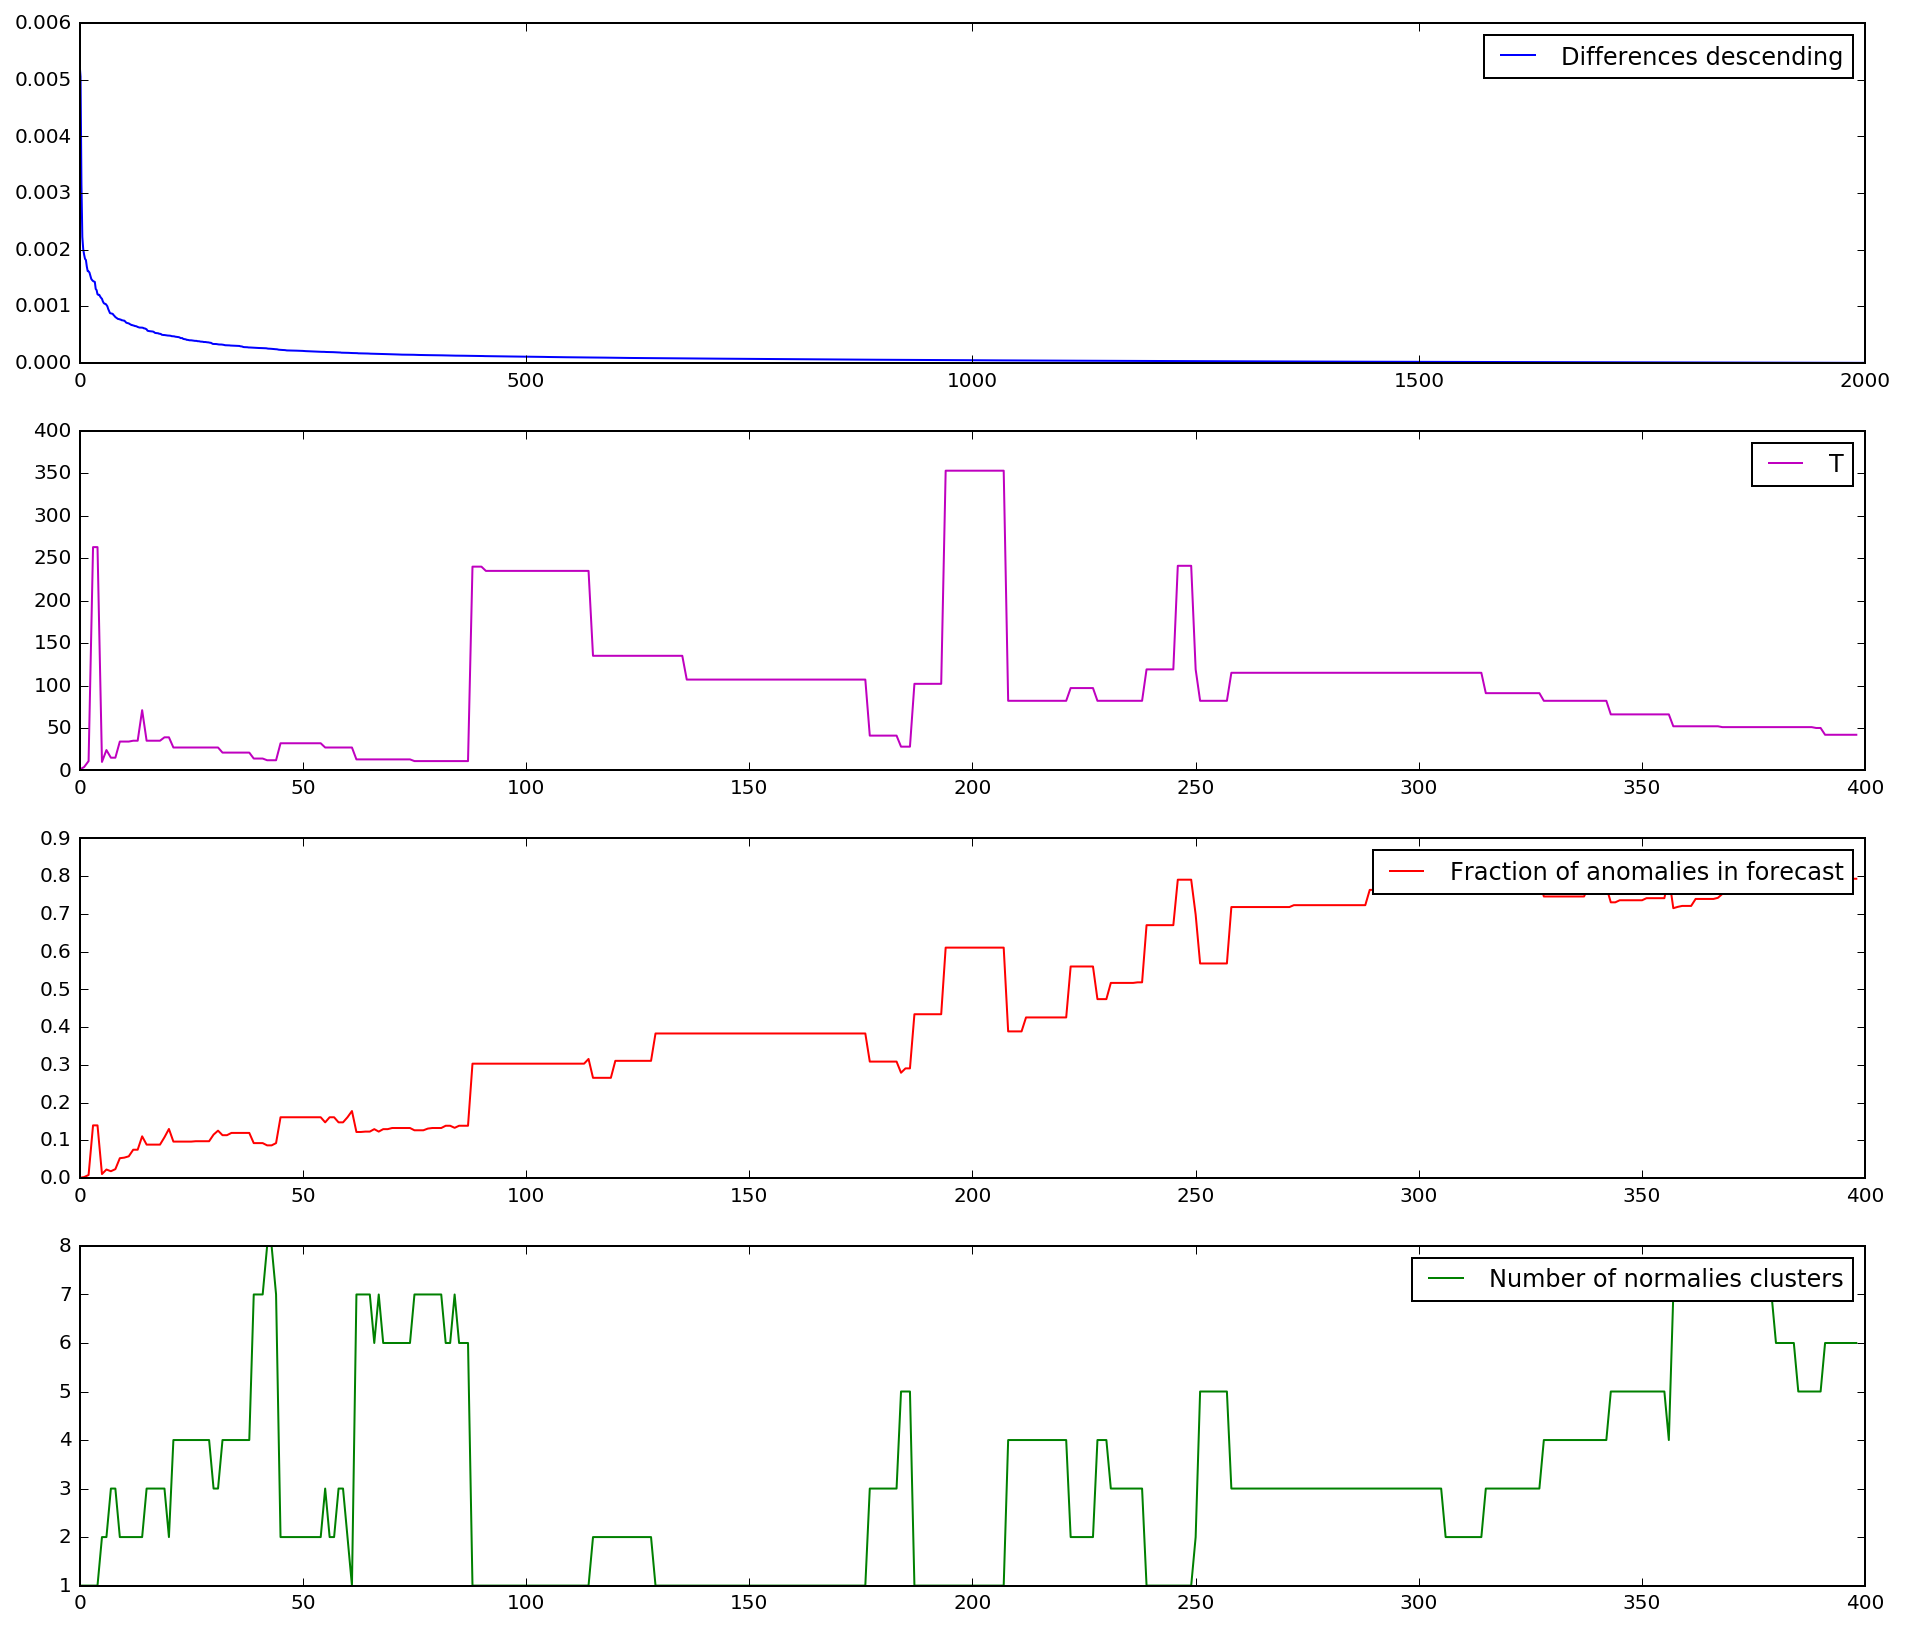

In [89]:
analize_threshold(normaly_score, anomaly_score, 400)

Известно, что Number of normalies clusters на самом деле желательно 1, anomaly_fraction ~ 0.33333.

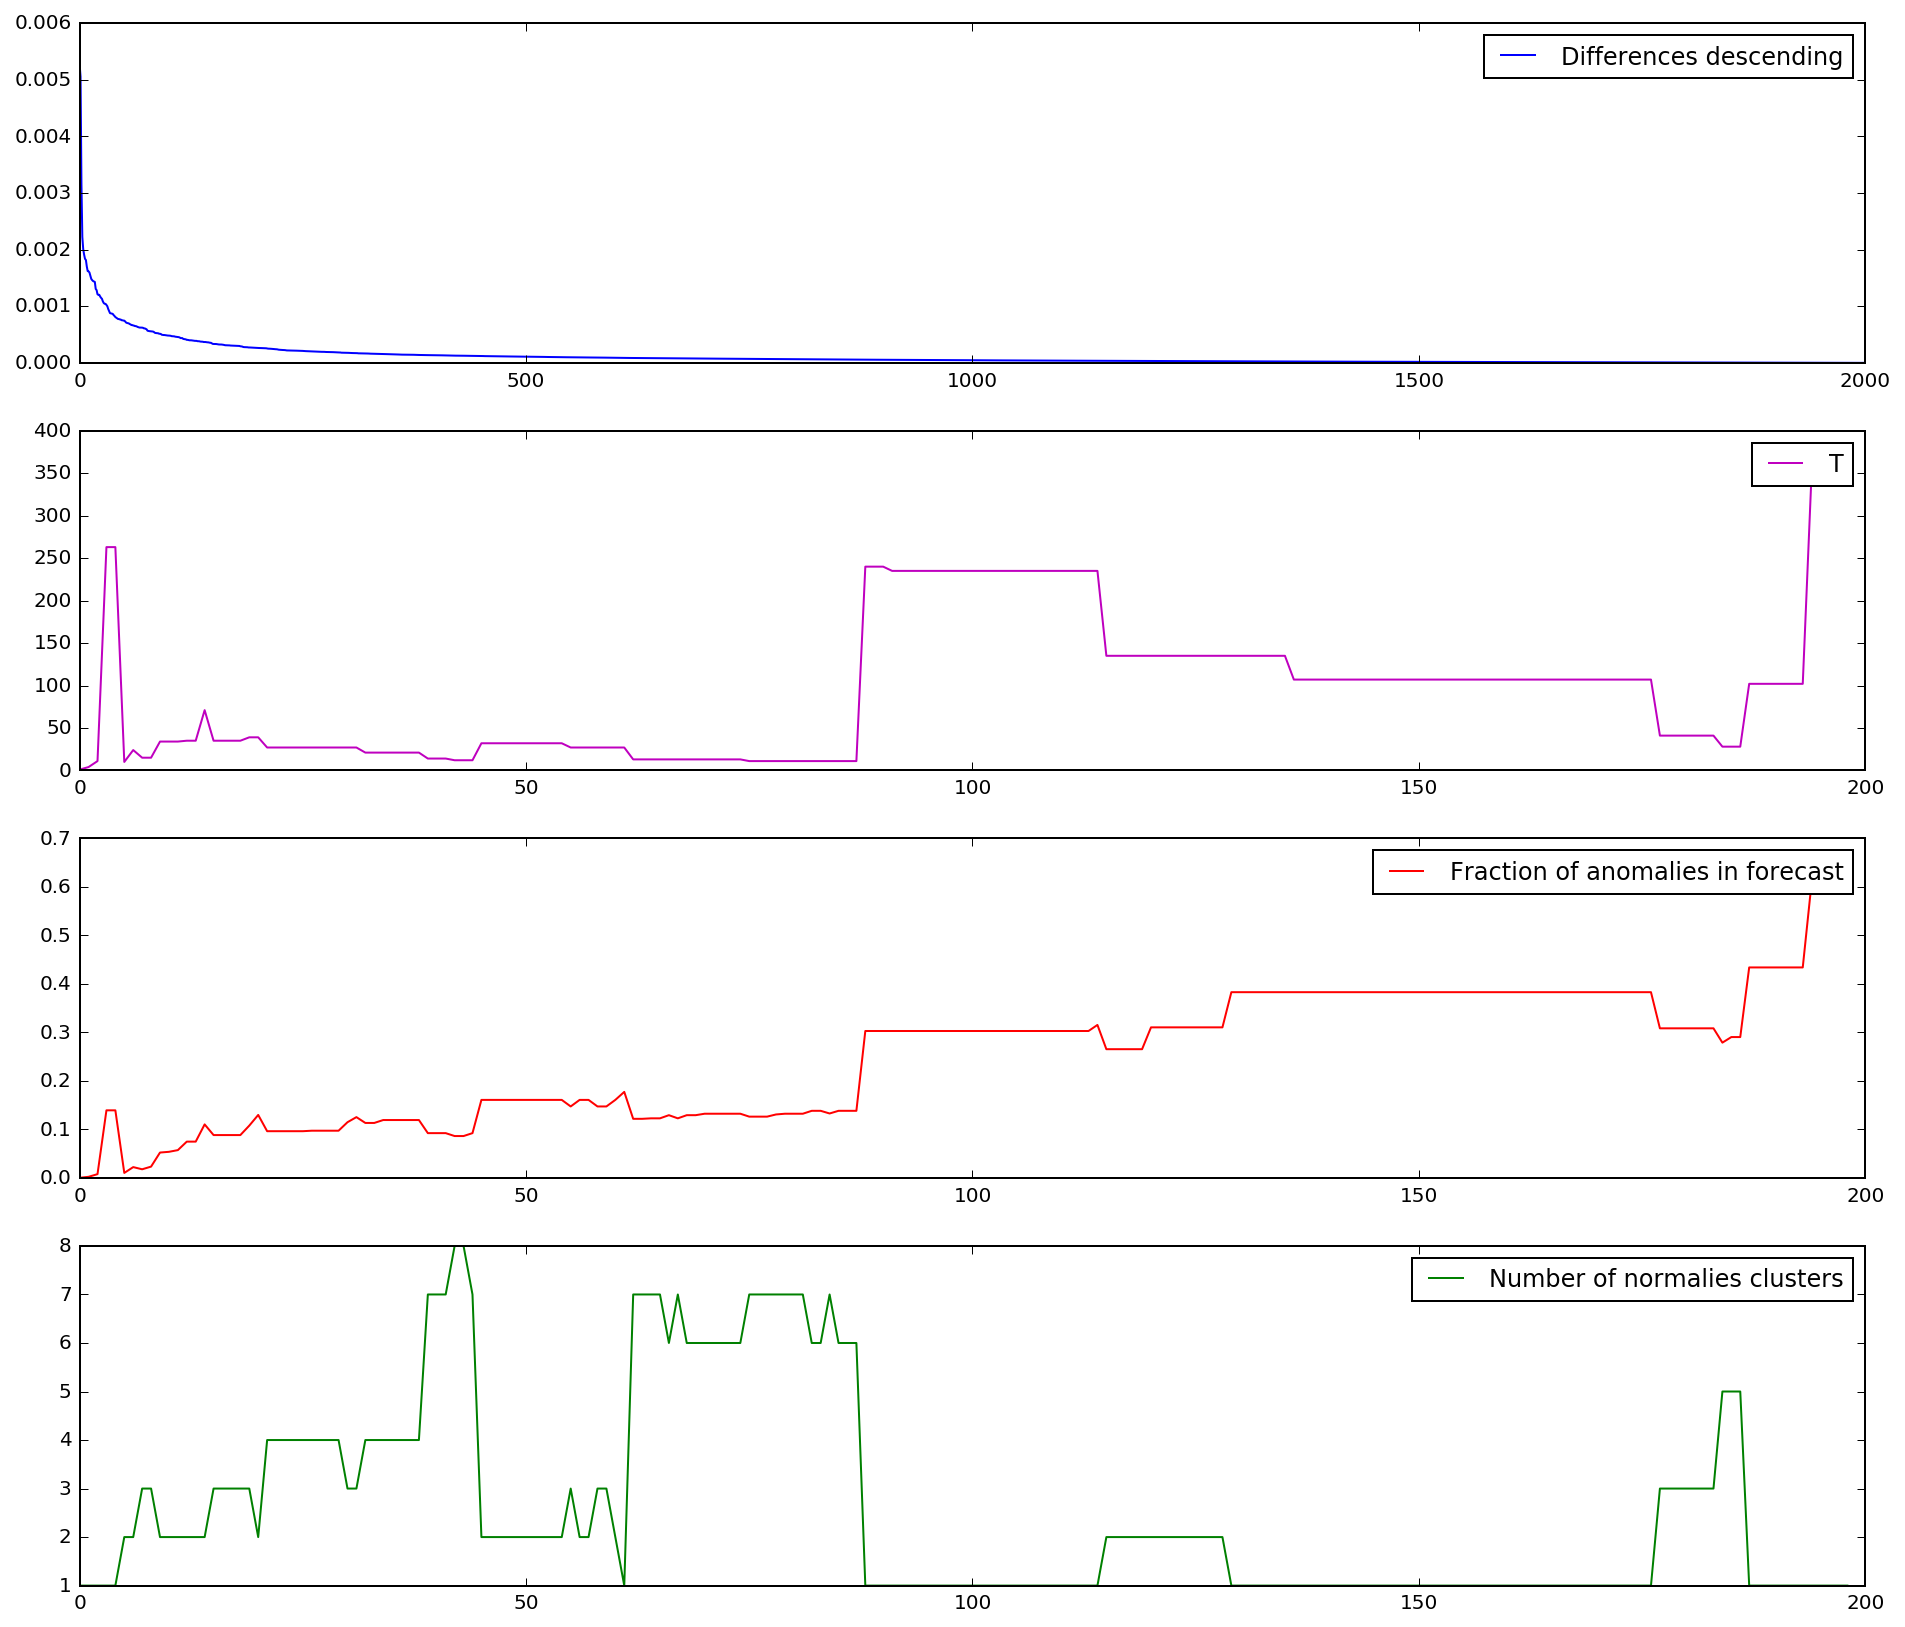

In [90]:
analize_threshold(normaly_score, anomaly_score, 200)

T =  107
Anomalies Fraction =  0.383 %


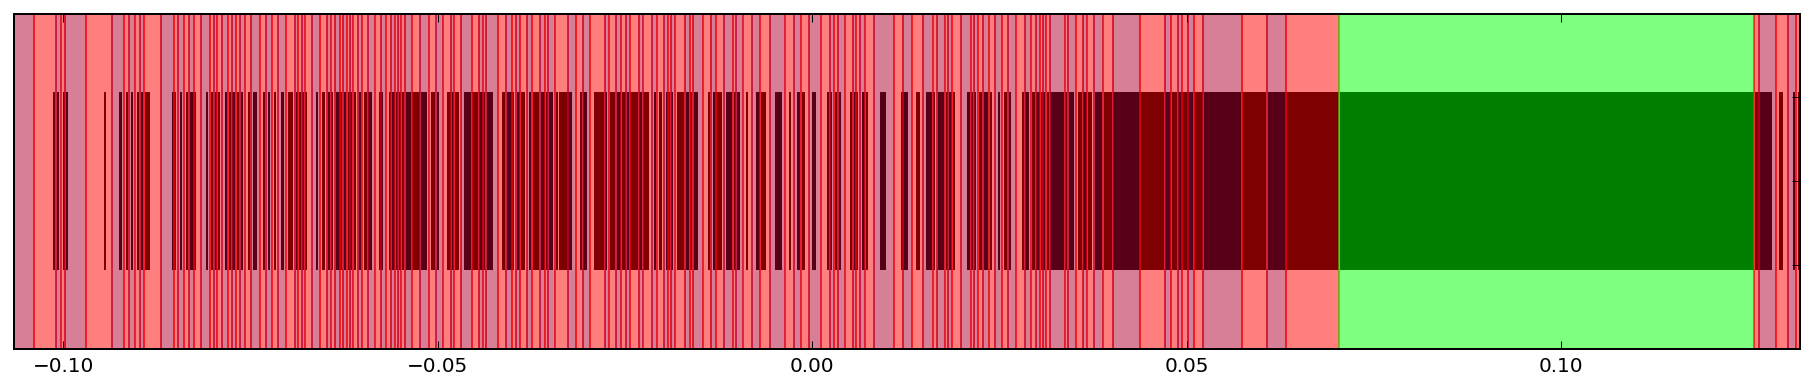

In [100]:
f = apply_threshold(normaly_score, anomaly_score, 177)

In [109]:
f_measure(np.append(np.zeros_like(normaly_score), np.ones_like(anomaly_score)), f)

precision =  0.584856396867
recall =  0.666666666667
f-measure =  0.623087621697


0.6230876216968011

Теперь сколько потенциально можно было выжать:

Potential max f-measure =  0.621212121212  (thr =  0.0536633196807 )


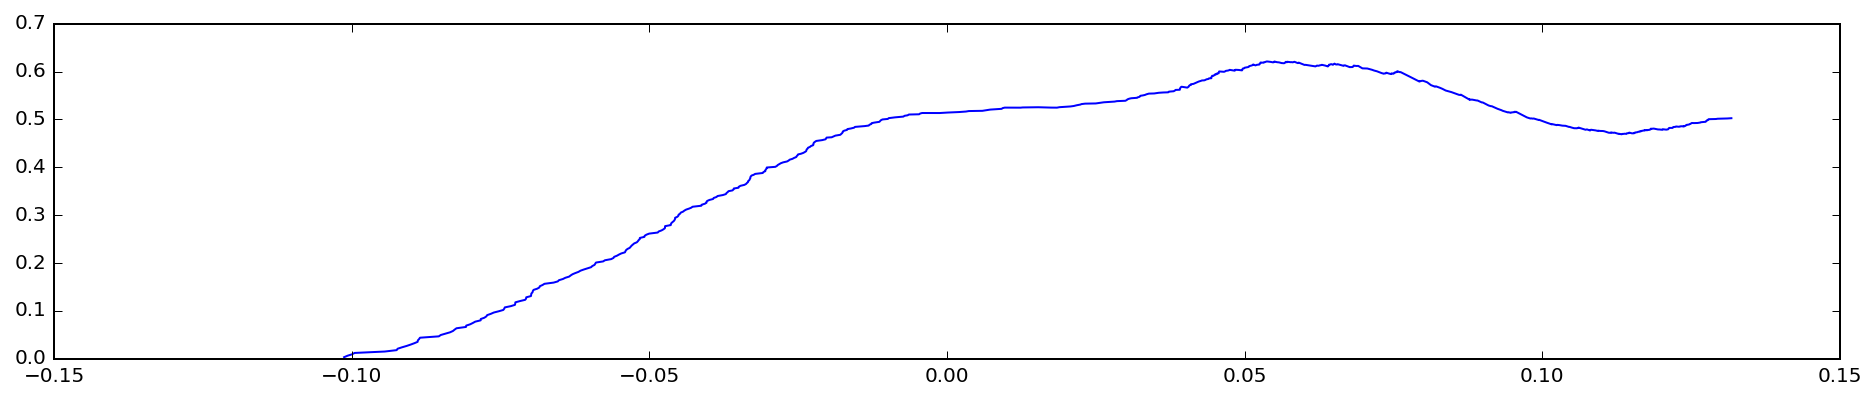

In [120]:
potential_f_measure(normaly_score, anomaly_score)

о_О, точки с высоким anomaly_score что ли на самом деле аномалии? как это так вообще?